# Time Series Project

Sales forecasting system
- We want to set up our company's warehouse in another location and we need to estimate the rate of sales, which has been increasing since the company's creation, for the next few months in order to provide the space we will need.

#### Step 1: Loading the dataset

In [1]:
import pandas as pd

total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
total_data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [2]:
total_data.tail()

,date,sales
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214
365,2023-09-03 17:10:08.079328,1000.482785


In [3]:
# Check dataset:

total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


#### Step 2: Constructing and analyzing the time serie

- Using dates as an index is common in time series analysis because it facilitates data access by date, allows the use of specialized methods for time series, and can improve the efficiency of certain operations.

In [4]:
# Transform date column to data_type:

total_data['date'] = pd.to_datetime(total_data['date'])
total_data.set_index('date', inplace=True)
total_data.head()

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


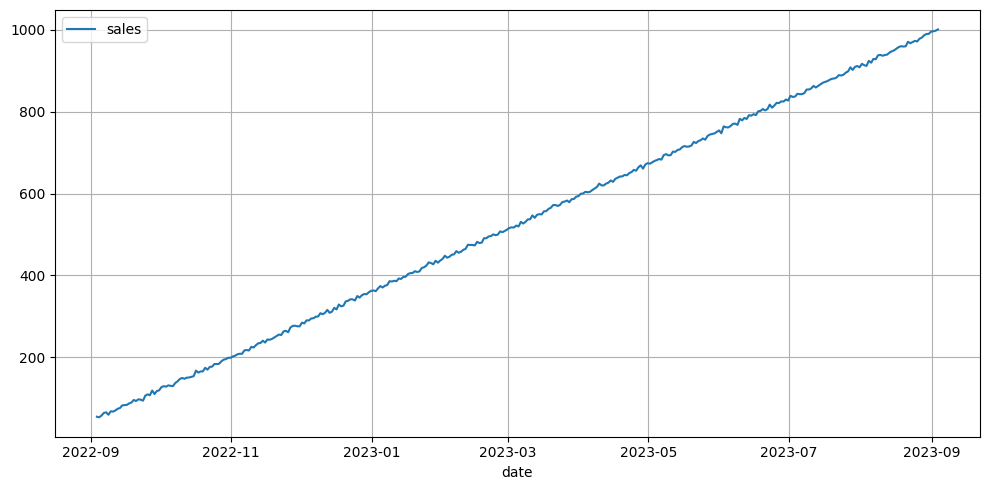

In [5]:
# Plot data to visualize:

import seaborn as sns
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

# Insert the Data

sns.lineplot(data = total_data)

# Adjust Plot

plt.tight_layout()
plt.grid(True)

# Plot

plt.show()

#### 2.1: Time series analysis

- Which is the tensor of the time serie?
     - The minimum time unit for which there is data is one day.

In [6]:
# Decompose the time series:

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(total_data, period = 30)
decomposition

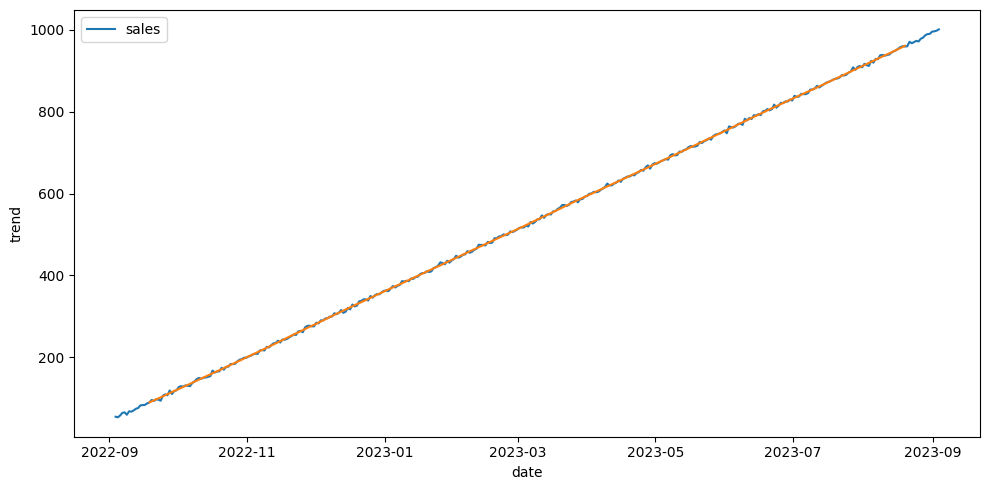

In [7]:
# Trend analysis:

trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_data)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

- Which is the trend?
    - An upward and linear trend is observed.

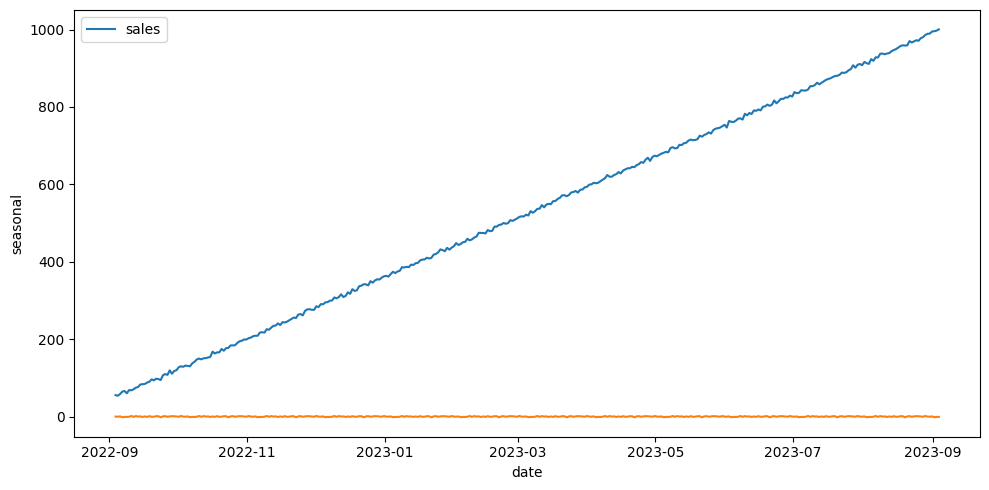

In [8]:
# Seasonality analysis:

seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_data)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()


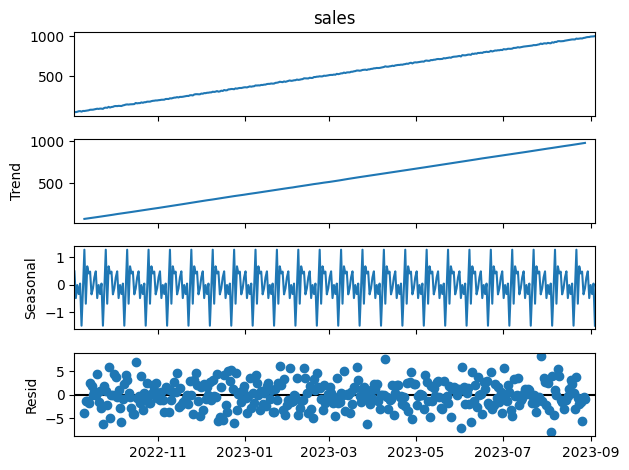

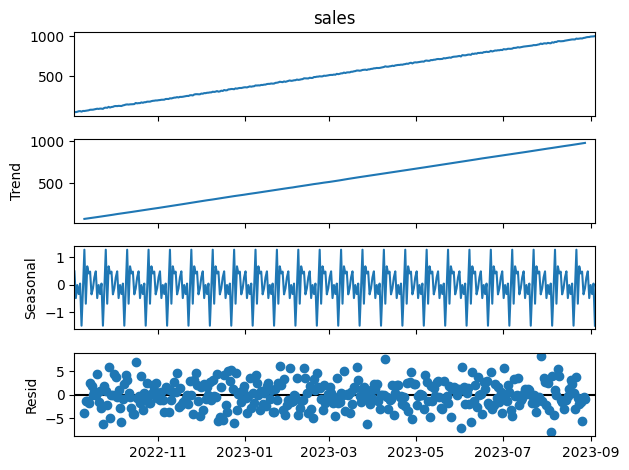

In [9]:
# Another way to calculate trend and seasonality for dataset:

result = seasonal_decompose(total_data['sales'], model='additive', period=15)
result.plot()

- ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not.
    - Null Hypothesis: The series has a unit root. Non-stationary serie.
    - Alternate Hypothesis: The series has no unit root.

- If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.
- Test Statistic: If this value is less than the critical values, it indicates that the series is stationary.
- p-value: If this value is less than the significance level (for example, 0.05), the series is stationary.

In [10]:
# Stationarity analysis:

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(total_data)

Dickey-Fuller test results:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Conclusions:
- Is it stationary?
    - p-value is greater than 0.05, which means that our null hypothesis will not be rejected, and we will take this serie as non-stationary.


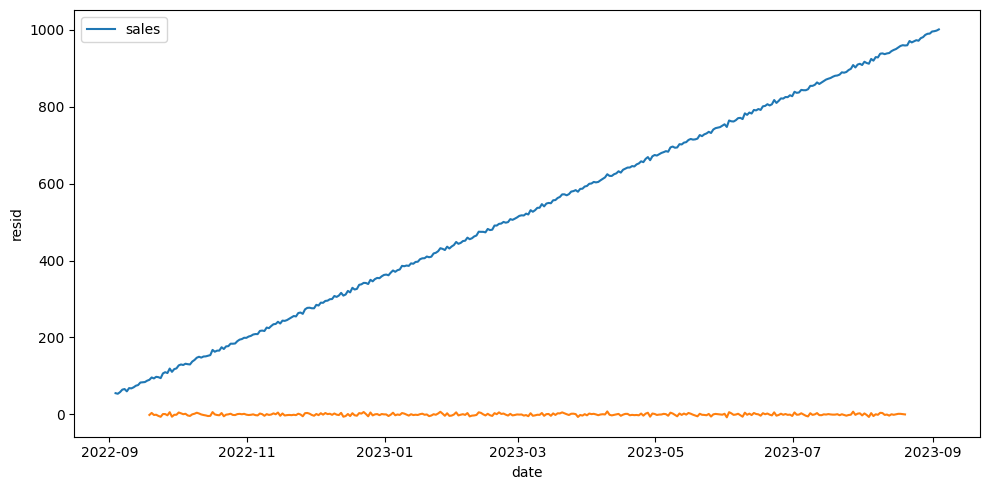

In [11]:
# Variability analysis:

residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_data)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

- Is there variability or noise?
    - There is just a few variability in the dataset.

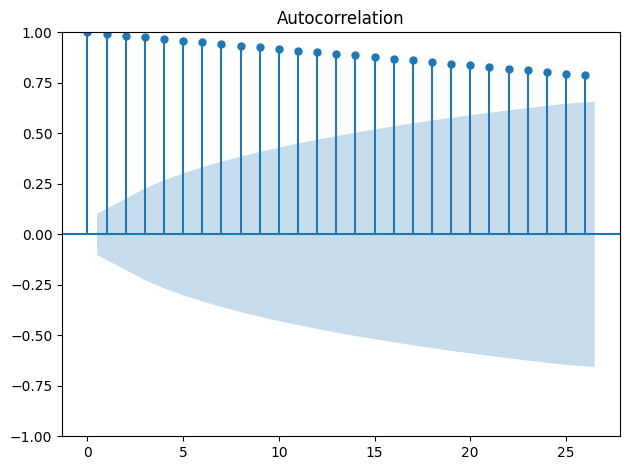

In [12]:
# Autocorrelation analysis:

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(total_data)

plt.tight_layout()

plt.show()

- There is a high correlation between the points and their delayed copies, which decreases over time.

#### Step 3: Train an ARIMA
- The only thing we have to consider is that in order to optimize the results to the maximum, we must transform the series into stationary, and as in the case of this series, it is not, we must transform it.

In [13]:
data_stationary = total_data.diff().dropna()

test_stationarity(data_stationary)

Dickey-Fuller test results:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

- Now the series is stationary, and we can apply the automatic ARIMA method:

In [24]:
from pmdarima import auto_arima

model = auto_arima(data_stationary, seasonal = True, trace = True, m = 30)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=1845.252, Time=4.55 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=1971.739, Time=0.56 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[30] intercept   : AIC=1843.274, Time=3.87 sec
 ARIMA(2,0,2)(0,0,0)[30] intercept   : AIC=1843.049, Time=0.40 sec
 ARIMA(2,0,2)(1,0,0)[30] intercept   : AIC=1843.220, Time=3.38 sec
 ARIMA(1,0,2)(0,0,0)[30] intercept   : AIC=1843.587, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[30] intercept   : AIC=1841.533, Time=0.33 sec
 ARIMA(2,0,1)(1,0,0)[30] intercept   : AIC=1841.467, Time=4.44 sec
 ARIMA(2,0,1)(2,0,0)[30] intercept   : AIC=1843.495, Time=16.60 sec
 ARIMA(2,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=3.89 sec
 ARIMA(2,0,1)(0,0,1)[30] intercept   : AIC=1841.425, Time=3.28 sec
 ARIMA(2,0,1)(0,0,2)[30] int

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 30)   Log Likelihood                -914.720
Date:                            Sun, 19 May 2024   AIC                           1839.439
Time:                                    13:25:21   BIC                           1858.939
Sample:                                09-04-2022   HQIC                          1847.188
                                     - 09-03-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8192      0.134     20.986      0.000       2.556       3.083
ar.L1         -0.0850      0.052     -1.641      0.101      -0.187       0.016
ma.L1         -0.9435      0.020    -47.190      0.000      -0.983      -0.904
ma.S.L30      -0.0806      0.061     -1.323      0.186      -0.200       0.039
sigma2         8.7304      0.683     12.788      0.000       7.392      10.068
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.99   Prob(JB):                         0.68
Heteroskedasticity (H):               0.92   Skew:                             0.07
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Step 4: Predict with the test set
- Once the model has been trained, it can be used to predict into the future (we will predict the next 60 days)

In [26]:
forecast = model.predict(30)
forecast

2023-09-04 17:10:08.079328    2.046149
2023-09-05 17:10:08.079328    2.162499
2023-09-06 17:10:08.079328    2.827505
2023-09-07 17:10:08.079328    2.042483
2023-09-08 17:10:08.079328    2.743390
2023-09-09 17:10:08.079328    2.940540
2023-09-10 17:10:08.079328    2.700119
2023-09-11 17:10:08.079328    2.713957
2023-09-12 17:10:08.079328    2.406173
2023-09-13 17:10:08.079328    2.549262
2023-09-14 17:10:08.079328    2.623742
2023-09-15 17:10:08.079328    2.473212
2023-09-16 17:10:08.079328    2.492436
2023-09-17 17:10:08.079328    2.652892
2023-09-18 17:10:08.079328    2.882323
2023-09-19 17:10:08.079328    2.762238
2023-09-20 17:10:08.079328    1.895069
2023-09-21 17:10:08.079328    3.122267
2023-09-22 17:10:08.079328    2.592938
2023-09-23 17:10:08.079328    2.547498
2023-09-24 17:10:08.079328    2.915993
2023-09-25 17:10:08.079328    2.220297
2023-09-26 17:10:08.079328    2.657565
2023-09-27 17:10:08.079328    2.298700
2023-09-28 17:10:08.079328    2.585472
2023-09-29 17:10:08.07932

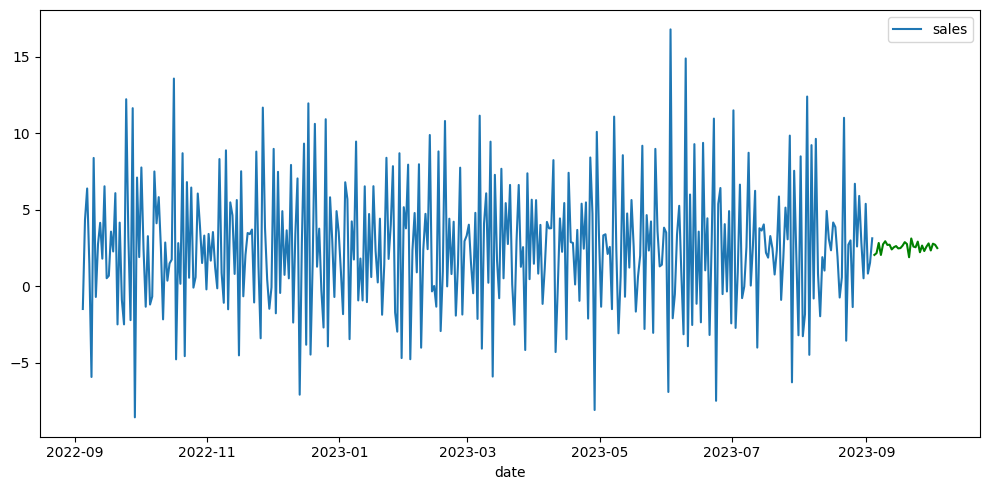

In [27]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = data_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

#### Step 5: Save the model

In [30]:
from joblib import dump

dump(model, open("/workspaces/machine-learning-time-series-Juli-MM/models/Arima_sales_30.sav", "wb"))